<h1>Introduction and Set Up</h1>

<p>This notebook will demonstrate how to assign trip starting points to Michigan census tracts and plot tracts that a trip has travelled through. It has been tested on:</p>
<ul>
    <li>geopandas: 0.2.1 </li>
    <li>pandas: 0.19.2</li>
    <li>shapely: 1.5.17</li>
    <li>pysal: 1.14.2</li>
</ul>

In [306]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import *
import pysal as ps
%matplotlib inline

<h3>Read In Data and Create GeoDataFrame</h3>
<p>In general, GeoPandas read spatial data into GeoDataFrame (or GeoSeries) while Pandas read text data (most often) into DataFrame (or Series). GeoDataFrame and DataFrame are highly comparable because common methods available to DataFrame can also be applied to GeoDataFrame.</p>
<p>One major difference between GeoDataFrame and DataFrame is that GeoDataFrame must have a column <strong>geometry</strong> which stores Shapely geometric objects. Common Shapely geometric objects include Point, Polygon, LineString. Less common geometric objects are collection of objects like MultiPoint, MultiPolygon, MultiLineString.</p>
<p>Geopandas can read almost any vector-based spatial data formate including widely used <strong>ESRI shapefile</strong>, <strong>GeoJSON</strong> by command: gpd.read_file().
<p>First we read in the Michigan census tract shape file, which can be found on <a href=""http://gis-michigan.opendata.arcgis.com/datasets/172a00f7218b455299682f4d76562757_13>Michigan GIS Data Portal</a>.</p>

In [3]:
filename = "2010_Census_Tracts_v17a.geojson"
mi_census = gpd.read_file(filename)

The geometry column  shows that most of the census tracts are polygons.

In [4]:
mi_census.head()

,OBJECTID,NAME,LABEL,TYPE,LINK,CNTY_CODE,SQKM,SQMILES,ACRES,VER,LAYOUT,PENINSULA,ShapeSTArea,ShapeSTLength,geometry
0,1,970100,Tract 9701,Tract,001970100,001,204.621,79.004,50562.495,17A,portrait,lower,2.046214e+08,80225.641570,POLYGON ((-83.40342246796628 44.68502773673926...
1,2,000100,Tract 0001,Tract,001000100,001,168.130,64.915,41545.324,17A,landscape,lower,1.681298e+08,52639.870882,(POLYGON ((-83.58911532322678 44.8053156248352...
2,3,970500,Tract 9705,Tract,001970500,001,920.748,355.501,227519.309,17A,portrait,lower,9.207479e+08,143070.374716,"POLYGON ((-83.88729210379145 44.614888452553, ..."
3,4,970400,Tract 9704,Tract,001970400,001,428.635,165.496,105916.824,17A,portrait,lower,4.286348e+08,103318.569067,"POLYGON ((-83.625013486627 44.59038565417478, ..."
4,5,970600,Tract 9706,Tract,001970600,001,76.424,29.507,18884.615,17A,landscape,lower,7.642415e+07,34597.247127,POLYGON ((-83.33373829371767 44.51176424727763...


Let's take a look at Washtenaw county tracts.

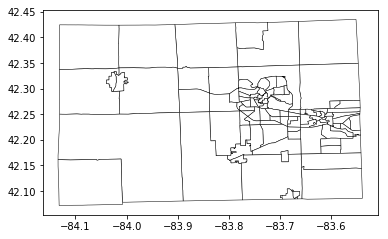

In [307]:
washtenaw = mi_census[mi_census.CNTY_CODE == "161"]
washtenaw.plot(color = "white", linewidth = 0.5,edgecolor="black")

Read in trip summary data (dataset <a href="https://github.com/caocscar/ConnectedVehicleDocs/blob/master/BSMdocumentation.md">documentation</a>).

In [410]:
metadata = "umtri_bsm_metadata.txt"
trip_df = pd.read_csv(metadata,usecols=list(range(2,9))+[17])
trip_df.head()

,RxDevice,fileId,TxDevice,firstLatitude,firstLongitude,lastLatitude,lastLongitude,distance
0,1104,76,-7029,42.449341,-83.752304,42.516045,-83.757439,4.64
1,1104,76,-1792,42.632069,-83.776802,42.630283,-83.853798,3.91
2,1104,76,-67,42.323597,-83.715752,42.379303,-83.756821,5.30
3,1104,76,3543,42.603577,-83.740303,42.632515,-83.766769,3.07
4,1104,76,11131,42.524647,-83.752205,42.595886,-83.740540,5.08


<p>Before doing spatial join or other sptial operations, it is always a good practice to project GeoDataFrames or GeoSeries to the same Coordinate Reference System.</p>
<p>Coordinate Reference System (CRS) are referred to using codes called __proj4__ strings. Commonly used code can be found at http://spatialreference.org.</p>
<p>In this example we'll stick to the standard WGS84 coordinate system which is speficed as {'init': 'epsg:4326'}.</p>

First check the tract gdf's crs, which is the standard system.

In [411]:
mi_census.crs

{'init': 'epsg:4326'}

Then create Point object using the starting lattitude and longtitude. Remember to specify crs when converting DataFrame to GeoDataFrame.

In [434]:
start_point_geometry = [Point(x,y) for x,y in zip(trip_df.firstLongitude, trip_df.firstLatitude)]
start_point_gdf = gpd.GeoDataFrame(trip_df, geometry=start_point_geometry,crs={'init': 'epsg:4326'})

In [435]:
start_point_gdf.head()

,RxDevice,fileId,TxDevice,firstLatitude,firstLongitude,lastLatitude,lastLongitude,distance,geometry
index_left,,,,,,,,,
0,1104,76,-7029,42.449341,-83.752304,42.516045,-83.757439,4.64,POINT (-83.75230400000001 42.449341)
1,1104,76,-1792,42.632069,-83.776802,42.630283,-83.853798,3.91,POINT (-83.776802 42.632069)
2,1104,76,-67,42.323597,-83.715752,42.379303,-83.756821,5.30,POINT (-83.71575199999999 42.323597)
3,1104,76,3543,42.603577,-83.740303,42.632515,-83.766769,3.07,POINT (-83.740303 42.603577)
4,1104,76,11131,42.524647,-83.752205,42.595886,-83.740540,5.08,POINT (-83.752205 42.52464699999999)


Check the number of census tracts and starting points.

In [414]:
mi_census.shape

(2773, 15)

In [415]:
start_point_gdf.shape

(4643842, 9)

In [436]:
start_in_mi = gpd.sjoin(start_point_gdf, mi_census, op= "within")

In [437]:
len(start_in_mi)

4454923

In [438]:
start_in_mi.head()

,RxDevice,fileId,TxDevice,firstLatitude,firstLongitude,lastLatitude,lastLongitude,distance,geometry,index_right,...,LINK,CNTY_CODE,SQKM,SQMILES,ACRES,VER,LAYOUT,PENINSULA,ShapeSTArea,ShapeSTLength
0,1104,76,-7029,42.449341,-83.752304,42.516045,-83.757439,4.64,POINT (-83.75230400000001 42.449341),1010,...,093744700,093,13.057,5.041,3226.467,17A,landscape,lower,1.305719e+07,16112.490564
37,1104,78,15871,42.447048,-83.752769,42.374840,-83.754349,5.35,POINT (-83.752769 42.447048),1010,...,093744700,093,13.057,5.041,3226.467,17A,landscape,lower,1.305719e+07,16112.490564
231,1104,87,-13220,42.458580,-83.754044,42.391914,-83.763435,4.89,POINT (-83.75404399999999 42.45858),1010,...,093744700,093,13.057,5.041,3226.467,17A,landscape,lower,1.305719e+07,16112.490564
496,1111,68278,21021,42.447636,-83.752716,42.370644,-83.751877,5.71,POINT (-83.75271600000001 42.447636),1010,...,093744700,093,13.057,5.041,3226.467,17A,landscape,lower,1.305719e+07,16112.490564
1115,1116,15960,15083,42.450432,-83.752213,42.522091,-83.750061,5.18,POINT (-83.752213 42.450432),1010,...,093744700,093,13.057,5.041,3226.467,17A,landscape,lower,1.305719e+07,16112.490564


In [439]:
start_in_mi['latdiff']=start_in_mi['lastLatitude']-start_in_mi['firstLatitude']
start_in_mi['lngdiff']=start_in_mi['lastLongitude']-start_in_mi['firstLongitude']
start_in_mi['latdiff']=start_in_mi['latdiff'].abs()
start_in_mi['lngdiff']=start_in_mi['lngdiff'].abs()
start_in_mi.sort_values(['distance','latdiff','lngdiff'],ascending=[False, False,False])

,RxDevice,fileId,TxDevice,firstLatitude,firstLongitude,lastLatitude,lastLongitude,distance,geometry,index_right,...,SQKM,SQMILES,ACRES,VER,LAYOUT,PENINSULA,ShapeSTArea,ShapeSTLength,latdiff,lngdiff
3336272,6636,6854334,6636,42.237915,-85.657372,43.041164,-102.397940,996.27,POINT (-85.657372 42.237915),747,...,29.758,11.489,7353.162,17A,portrait,lower,2.975751e+07,25882.008579,0.803249,16.740568
783121,3110,104849,3110,42.245087,-83.588936,42.245319,-83.589058,743.76,POINT (-83.588936 42.245087),2106,...,3.556,1.373,878.666,17A,landscape,lower,3.555873e+06,11224.841521,0.000232,0.000122
2459141,3279,4202734,3279,41.765224,-86.741150,90.000000,180.000000,630.09,POINT (-86.74115 41.765224),137,...,59.010,22.784,14581.558,17A,landscape,lower,5.901011e+07,36540.582750,48.234776,266.741150
1204196,6357,2503363,6357,42.336517,-83.042030,44.023361,-90.508362,543.88,POINT (-83.04203000000001 42.336517),2522,...,2.079,0.803,513.788,17A,landscape,lower,2.079247e+06,7354.493330,1.686844,7.466332
1499501,7367,2191009,7367,42.269226,-84.583496,42.324951,-83.422012,478.58,POINT (-84.583496 42.269226),670,...,187.837,72.524,46415.003,17A,landscape,lower,1.878369e+08,58172.415888,0.055725,1.161484
275764,2758,712232,2758,42.292721,-83.669174,42.292759,-83.669121,468.78,POINT (-83.669174 42.292721),2062,...,40.053,15.464,9897.125,17A,landscape,lower,4.005268e+07,43426.758139,0.000038,0.000053
789267,3110,104851,3110,42.245018,-83.589386,42.244755,-83.588379,457.53,POINT (-83.589386 42.245018),2106,...,3.556,1.373,878.666,17A,landscape,lower,3.555873e+06,11224.841521,0.000263,0.001007
1900039,6851,4227372,6851,42.350651,-83.096725,44.272278,-76.914101,377.08,POINT (-83.09672500000001 42.350651),2498,...,1.605,0.620,396.634,17A,landscape,lower,1.605136e+06,5758.654881,1.921627,6.182624
4585128,6509,9628922,6509,42.000050,-83.678978,37.172001,-84.127678,376.55,POINT (-83.678978 42.00005),1327,...,94.207,36.373,23278.689,17A,landscape,lower,9.420652e+07,38809.462595,4.828049,0.448700
1113938,6975,2175141,6975,42.126892,-83.683197,39.987518,-78.705566,354.98,POINT (-83.68319699999999 42.126892),2149,...,87.142,33.646,21533.121,17A,portrait,lower,8.714239e+07,50124.459898,2.139374,4.977631


In [440]:
metadata = "umtri_bsm_metadata.txt"
metadata_df = pd.read_csv(metadata,usecols=list(range(0,9))+[17])
metadata_df.head()

,TripStart,fileNum,RxDevice,fileId,TxDevice,firstLatitude,firstLongitude,lastLatitude,lastLongitude,distance
0,41092,1,1104,76,-7029,42.449341,-83.752304,42.516045,-83.757439,4.64
1,41092,1,1104,76,-1792,42.632069,-83.776802,42.630283,-83.853798,3.91
2,41092,1,1104,76,-67,42.323597,-83.715752,42.379303,-83.756821,5.30
3,41092,1,1104,76,3543,42.603577,-83.740303,42.632515,-83.766769,3.07
4,41092,1,1104,76,11131,42.524647,-83.752205,42.595886,-83.740540,5.08


In [442]:
metadata_df[(metadata_df['RxDevice']==6577)&(metadata_df['fileId']==7126819)&(metadata_df['TxDevice']==6577)]

,TripStart,fileNum,RxDevice,fileId,TxDevice,firstLatitude,firstLongitude,lastLatitude,lastLongitude,distance
3191213,41728,38,6577,7126819,6577,41.776371,-86.728645,42.288624,-83.817123,343.68


<h3>Assigning Points to Correct Census Tract Using Spatial Join</h3>
<p><strong>Spatial join</strong> is to join two geometric object based on their sptial locations. GeoPandas can readily spatial join two geometric obejcts using the <strong>sjoin</strong> function. The example below shows how to spatial join census tracts with starting points.</p>
<p>The <strong>"op"</strong> parameter specifies the relationship between the first and second geometric object. The options can be <strong>"within", "contains" or "intersects"</strong>. Pay attention to the sequence of objects and the option when doing spatial join.</p>

We'll use 10000 randomly selected points in this example.

In [314]:
start_point_sample = start_point_gdf.sample(10000)

In [315]:
start_point_sample.head()

,RxDevice,fileId,TxDevice,firstLatitude,firstLongitude,lastLatitude,lastLongitude,geometry
3018029,9536,7241519,9536,42.243221,-83.745514,42.282330,-83.732155,POINT (-83.745514 42.24322100000001)
665590,2620,1382369,2620,42.254864,-83.680885,42.247990,-83.738197,POINT (-83.680885 42.254864)
2877271,11101,6223677,11101,42.493263,-83.409782,42.282360,-83.750946,POINT (-83.40978199999999 42.493263)
1076178,11501,2308176,11501,42.253788,-83.679161,42.316444,-83.648849,POINT (-83.67916099999999 42.253788)
252066,6659,911988,6659,42.293972,-83.718185,42.322983,-83.840309,POINT (-83.71818499999999 42.293972)


Find trips that start in Washtenaw county.

In [316]:
start_in_washtenaw = gpd.sjoin(start_point_sample, washtenaw, op= "within")

In [317]:
start_in_washtenaw.head()

,RxDevice,fileId,TxDevice,firstLatitude,firstLongitude,lastLatitude,lastLongitude,geometry,index_right,OBJECTID,...,LINK,CNTY_CODE,SQKM,SQMILES,ACRES,VER,LAYOUT,PENINSULA,ShapeSTArea,ShapeSTLength
3018029,9536,7241519,9536,42.243221,-83.745514,42.282330,-83.732155,POINT (-83.745514 42.24322100000001),2099,2100,...,161404500,161,3.787,1.462,935.865,17A,portrait,lower,3.787353e+06,8536.074039
3108384,11101,6227529,11101,42.242775,-83.739403,42.287998,-83.692696,POINT (-83.739403 42.242775),2099,2100,...,161404500,161,3.787,1.462,935.865,17A,portrait,lower,3.787353e+06,8536.074039
3985772,2023,8213929,2023,42.243290,-83.742165,42.232075,-83.741516,POINT (-83.742165 42.24329),2099,2100,...,161404500,161,3.787,1.462,935.865,17A,portrait,lower,3.787353e+06,8536.074039
391563,11511,221142,11511,42.254738,-83.751686,42.282795,-83.747162,POINT (-83.75168599999999 42.254738),2099,2100,...,161404500,161,3.787,1.462,935.865,17A,portrait,lower,3.787353e+06,8536.074039
4492853,9507,9688949,9507,42.246006,-83.749397,42.235867,-83.727448,POINT (-83.749397 42.246006),2099,2100,...,161404500,161,3.787,1.462,935.865,17A,portrait,lower,3.787353e+06,8536.074039


Plot them on the washtenaw tracts:

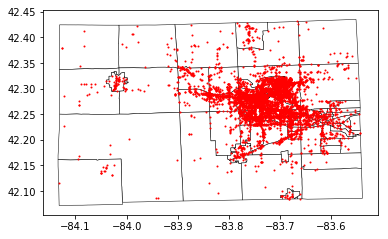

In [318]:
base = washtenaw.plot(color = "white", linewidth = 0.5,edgecolor="black")
start_in_washtenaw.plot(ax = base,markersize = 1,color="red")

<h3>Plotting a trip</h3>
<p>In the trip summary data, each row represents one trip and only has start and end point locations. To plot a complete trip we need to read in the detailed vehicle activity data (dataset <a href="https://github.com/caocscar/ConnectedVehicleDocs/blob/master/BSMdocumentation.md">documentation</a>). </p>

In [465]:
point_df = pd.read_csv("TripStart_41728_p038.csv",header=None,usecols=[0,1,2,3]+[7,8])
point_df.columns =['RxDevice','fileId','TxDevice','Gentime','Latitude','Longitude']
point_df.head()

,RxDevice,fileId,TxDevice,Gentime,Latitude,Longitude
0,6512,7125966,6512,323254442760265,43.437309,-83.939384
1,6512,7125966,6512,323254442860111,43.437302,-83.939346
2,6512,7125966,6512,323254442960170,43.437294,-83.939308
3,6512,7125966,6512,323254443060049,43.437290,-83.939270
4,6512,7125966,6512,323254443160143,43.437283,-83.939232


In this dataset each row represents the vehicle's location at that particular moment. Let's merge it with the summary dataset on shared columns to see how many intermediate points a trip has.

In [466]:
merge_df=pd.merge(trip_df,point_df,how="inner")

In [467]:
merge_df.head()

,RxDevice,fileId,TxDevice,firstLatitude,firstLongitude,lastLatitude,lastLongitude,distance,geometry,Gentime,Latitude,Longitude
0,6512,7125966,6512,43.437309,-83.939384,42.973461,-83.730125,36.72,POINT (-83.93938399999999 43.437309),323254442760265,43.437309,-83.939384
1,6512,7125966,6512,43.437309,-83.939384,42.973461,-83.730125,36.72,POINT (-83.93938399999999 43.437309),323254442860111,43.437302,-83.939346
2,6512,7125966,6512,43.437309,-83.939384,42.973461,-83.730125,36.72,POINT (-83.93938399999999 43.437309),323254442960170,43.437294,-83.939308
3,6512,7125966,6512,43.437309,-83.939384,42.973461,-83.730125,36.72,POINT (-83.93938399999999 43.437309),323254443060049,43.437290,-83.939270
4,6512,7125966,6512,43.437309,-83.939384,42.973461,-83.730125,36.72,POINT (-83.93938399999999 43.437309),323254443160143,43.437283,-83.939232


Now the merged dataset has all the points we need. We can label the point state.

In [468]:
def label_point(row):
    if (row.Latitude,row.Longitude) == (row.firstLatitude,row.firstLongitude):
        return "start"
    elif (row.Latitude,row.Longitude) == (row.lastLatitude,row.lastLongitude):
        return "end"
    else:
        return "intermediate"   

In [469]:
merge_df['point_label'] = merge_df.apply (lambda row: label_point (row),axis=1)
merge_df.head()

,RxDevice,fileId,TxDevice,firstLatitude,firstLongitude,lastLatitude,lastLongitude,distance,geometry,Gentime,Latitude,Longitude,point_label
0,6512,7125966,6512,43.437309,-83.939384,42.973461,-83.730125,36.72,POINT (-83.93938399999999 43.437309),323254442760265,43.437309,-83.939384,start
1,6512,7125966,6512,43.437309,-83.939384,42.973461,-83.730125,36.72,POINT (-83.93938399999999 43.437309),323254442860111,43.437302,-83.939346,intermediate
2,6512,7125966,6512,43.437309,-83.939384,42.973461,-83.730125,36.72,POINT (-83.93938399999999 43.437309),323254442960170,43.437294,-83.939308,intermediate
3,6512,7125966,6512,43.437309,-83.939384,42.973461,-83.730125,36.72,POINT (-83.93938399999999 43.437309),323254443060049,43.437290,-83.939270,intermediate
4,6512,7125966,6512,43.437309,-83.939384,42.973461,-83.730125,36.72,POINT (-83.93938399999999 43.437309),323254443160143,43.437283,-83.939232,intermediate


Let's look at the number of points each trip has.

In [470]:
merge_df.groupby(['RxDevice','fileId','TxDevice']).size()

RxDevice  fileId   TxDevice
6512      7125966  6512         18328
6518      7223303  6518          7544
6565      7716380  6565          4959
          7716382  6565          2062
          7716383  6565          1331
          7716384  6565          3821
          7716385  6565          8700
          7716386  6565          6340
6567      7126620  6567          3250
6576      7417845  6576          4990
          7417846  6576         20181
          7417849  6576          8682
          7417851  6576         17625
6577      7126818  6577         75024
          7126819  6577        183118
6583      7640237  6583         24476
6589      6951266  6589          8182
          6951267  6589         17832
6594      7308870  6594         13918
6600      7224320  6600          4228
          7224321  6600          4370
          7224322  6600          1950
          7224323  6600          2671
          7224324  6600          5804
          7224325  6600          6104
6604      6789502  660

Use the longest trip as an example, we can plot out the tracts a trip has been through using the spatial join method covered earlier.

In [471]:
idx = merge_df.groupby(['RxDevice','fileId','TxDevice']).groups[(6577, 7126819, 6577)]

In [475]:
trip_sample = merge_df.iloc[idx]

In [477]:
trip_point_geometry = [Point(x,y) for x,y in zip(trip_sample.Longitude, trip_sample.Latitude)]
trip_points = gpd.GeoDataFrame(trip_sample, geometry=trip_point_geometry,crs={'init': 'epsg:4326'})
trip_tracts = gpd.sjoin(mi_census, trip_points, op= "contains")

Create different layers we want to plot.

In [479]:
start_point = trip_points[trip_points['point_label']=="start"]
end_point = trip_points[trip_points['point_label']=="end"]
start_tract = trip_tracts[trip_tracts['point_label']=="start"].reset_index()
end_tract = trip_tracts[trip_tracts['point_label']=="end"].reset_index()
inter_tracts = trip_tracts[trip_tracts['point_label']=="intermediate"].drop_duplicates("OBJECTID")
for i,row in inter_tracts.iterrows():
    if row['OBJECTID'] == start_tract.at[0,'OBJECTID'] or row['OBJECTID'] == end_tract.at[0,'OBJECTID']:
        inter_tracts.drop(i,inplace=True)

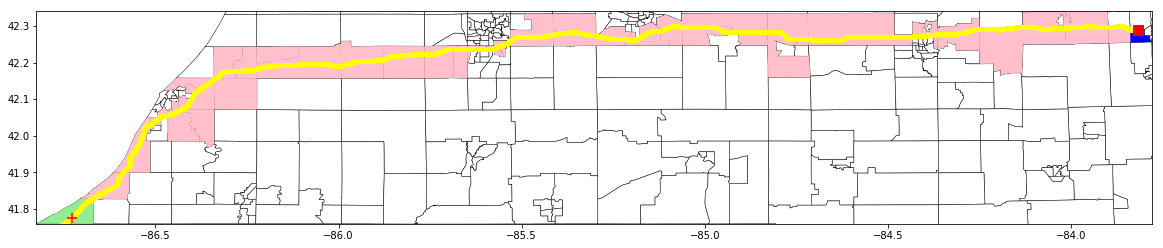

In [486]:
base = mi_census.plot(color = "white", linewidth = 0.5,edgecolor="black",figsize=(20,20))
minx, miny, maxx, maxy = trip_tracts.total_bounds
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)
start_tract.plot(ax=base,color="lightgreen")
end_tract.plot(ax=base,color="blue")
inter_tracts.plot(ax=base,color="pink")
trip_points.plot(ax=base,color="yellow",markersize=10)
start_point.plot(ax=base,color="red",markersize=100,marker="+")
end_point.plot(ax=base,color="red",markersize=100,marker="s")